# Agrupamento de Chamados por Temas

### Contextualização

Temos uma mini massa de dados, com diversos chamados e muitos deles tem a ver com o mesmo assunto, precisamos agrupar esses chamados por temas para criar uma categoria para eles.

### Objetivo da Análise

O objetivo é criar e treinar um modelo em python, para gerar esses agrupamentos e nos dizer qual grupo cada chamado desse pertence processando as descrições e características dos chamados.

Com isso, usarei nesse notebook o k-means, um algoritmo de agrupamento não supervisionado, para agrupar os chamados em diferentes grupos e categorias. Além de criar uma coluna a mais com o grupo gerado, e retornar novamente o arquivo.


##### O processo foi dividido nas seguintes etapas:

- Pré-processamento do Conjunto de Dados  

- Remoção de Stopwords

- Remoção de Ruído no texto

- Função TF-IDF

- K-Means

- Silhouette Score

- Cluster Analysis

- Mapa de Palavras por Cluster

- Preparando o Grupo e Definindo as Categorias

- Categorias mais Comuns

- Conclusão  


### 1. Pré-processamento do Conjunto de Dados

In [2]:
# Estrutura dos Dados
import pandas as pd
import numpy as np

#Processamento do Texto e Tokenização
import re
import nltk
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# K-means
from sklearn import cluster

# Visualização e Análise
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud


In [3]:
# Carregando os dados
df = pd.read_excel('../datasets/BASE_P_TESTE.xlsx')
df

,TIPO_CHAMADO,DS_FRENTE_CHAMADO,DS_DESCRICAO_CHAMADO,LOG_INTERACAO
0,INCIDENTE,B1,#0121-000006,Favor incluir o código ANP nas utilizações em ...
1,INCIDENTE,B1,#0121-000009,Favor validar porque na carga é permitido e na...
2,INCIDENTE,B1,PERIODO CONTABIL,Bom dia! Ao tentar fazer os lançamentos com a...
3,INCIDENTE,B1,#0121-000015,"O relatório de Movimentações, em Granel Relató..."
4,INCIDENTE,B1,#0121-000022,Ao extrair o relatório de cliente das filiais ...
...,...,...,...,...
2022,INCIDENTE,B1,ERRO - NFSE,Boa tarde! Tudo bem? Preciso de Suporte refer...
2023,INCIDENTE,B1,AGENDAMENTO TREINAMENTO DOCPAY,"Bom dia Conforme combinado, solicito o agenda..."
2024,INCIDENTE,B1,LINK PL 235,"Bom dia, Por gentileza, disponibilizar o Lin..."
2025,INCIDENTE,B1,#0723-000348,"Bom dia, Estou abrindo novamente um chamado r..."


In [4]:
# Separando a Coluna 'LOG_INTERACAO' em uma Lista
corpus = df['LOG_INTERACAO'].tolist()
corpus[0][0:450]

'Favor incluir o código ANP nas utilizações em anexo. Colocar o código 999 pois esses produtos não são controlados.   '

### Remoção de Stopwords

In [5]:
# Removendo uma lista de palavras que não fazem sentido 
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# Removendo palavras menores que 2 letras e maiores que 46
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 46:
            twoLetterWord.append(token)
    return twoLetterWord

### Remoção de Ruído no texto

In [6]:
# Removendo alguns ruídos para melhorar a análise
def processCorpus(corpus):
    stopwords = nltk.corpus.stopwords.words('portuguese')

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(',', '')          #removendo as vírgulas
        corpus[index] = corpus[index].replace('bom', 'str')     #removendo 
        corpus[index] = corpus[index].replace('dia', 'str')     #removendo 
        corpus[index] = corpus[index].replace('boa', 'str')     #removendo 
        corpus[index] = corpus[index].replace('tarde', 'str')   #removendo 
        corpus[index] = corpus[index].replace('bruna', 'str')   #removendo
        corpus[index] = corpus[index].replace('talyta', 'str')  #removendo
        corpus[index] = corpus[index].rstrip('\n')              #removendo todas as quebras de linhas
        corpus[index] = corpus[index].casefold()                #deixa todas as letras minúsculas
        corpus[index] = re.sub('\W_',' ', corpus[index])        #removendo caracteres especiais
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   #removendo números e palavras concatenadas com números
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) #removendo emails e menções com @
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   #removendo URLs http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    #removendo URLs com www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
   
        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [7]:
corpus = processCorpus(corpus)
corpus[0][0:500]

'favor incluir codigo anp utilizacoes anexo colocar codigo pois produtos controlados'

### Função TF-IDF (Term Frequncy Inverse Document Frequency) 
Estatística numérica que visa refletir a importância de uma palavra para um docuemto

In [8]:
# Aplicando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

2027 rows


,0,1,2,3,4,5,6,7,8,9,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
codigo,0.445397,0.14573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.191435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
controlados,0.424025,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
utilizacoes,0.402322,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anp,0.386923,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
produtos,0.309473,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
codigo,0.445397,0.14573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.191435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
controlados,0.424025,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
utilizacoes,0.402322,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anp,0.386923,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
produtos,0.309473,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-Means


In [10]:
# Executa o algoritmo K-Means 'max_k' vezes e retorna um dicionário
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

### Silhouette Score


In [11]:
# O Silhouette Score é uma medida de quão semelhante um objeto é ao seu próprio cluster em comparação com outros clusters.
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # Linha vertical para pontuação média
    ax1.set_yticks([])  # Limpando yaxis labels
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Calcule as pontuações da silhueta para cada amostra
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Rotule os gráficos de silhueta com seus números de cluster no meio
        y_lower = y_upper + 10  
    plt.show()

def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Pontuação média para as amostras
        avg_dict.update( {silhouette_avg : n_clusters} )

        if(plot): 
            plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

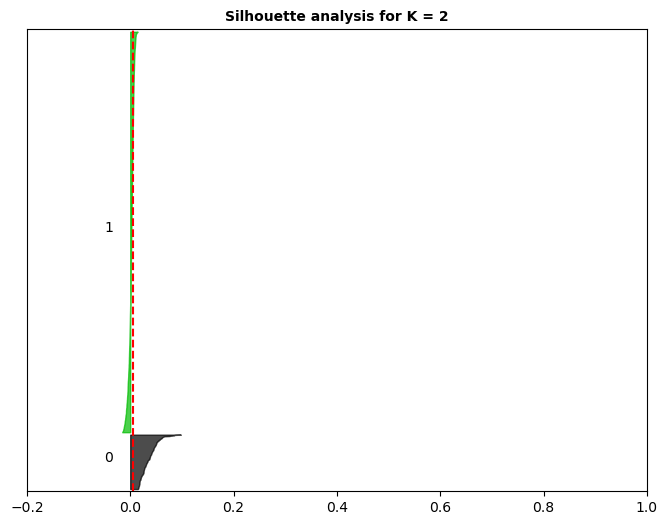

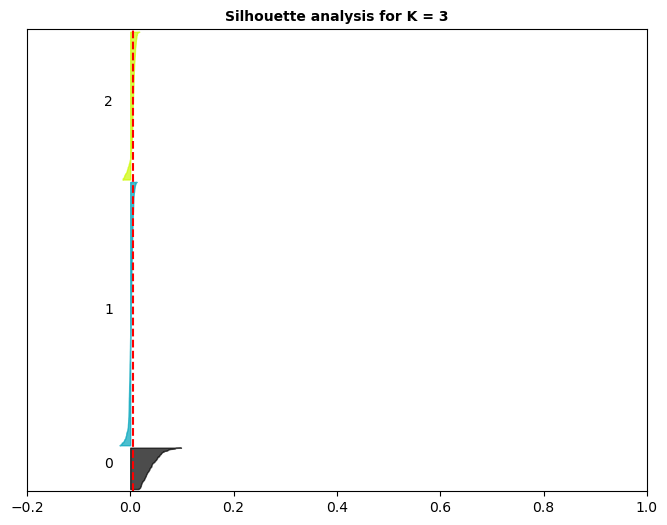

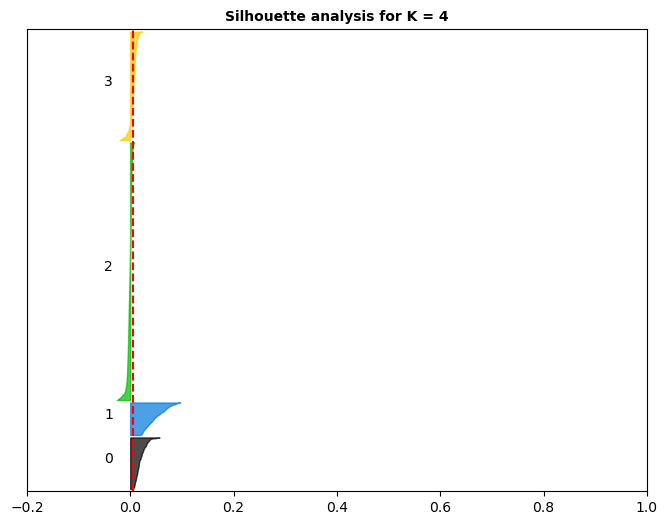

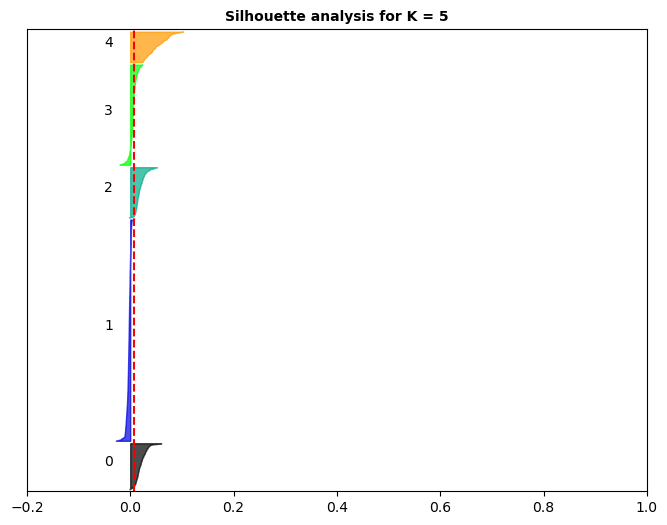

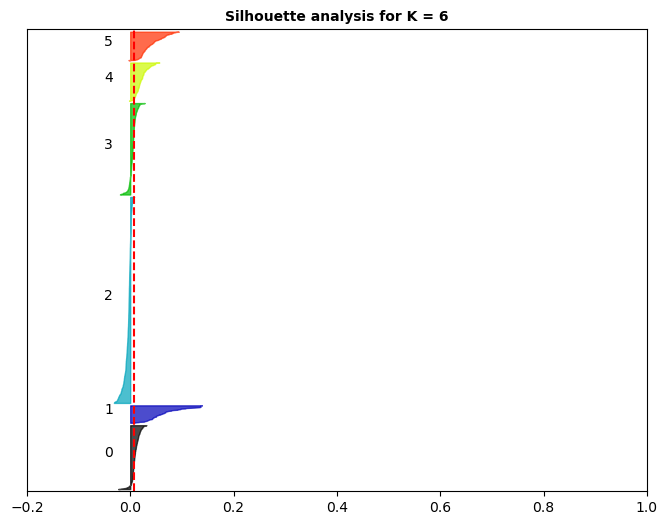

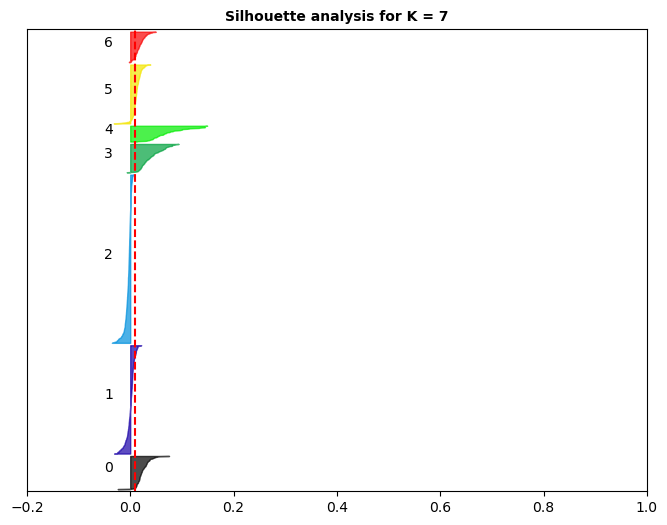

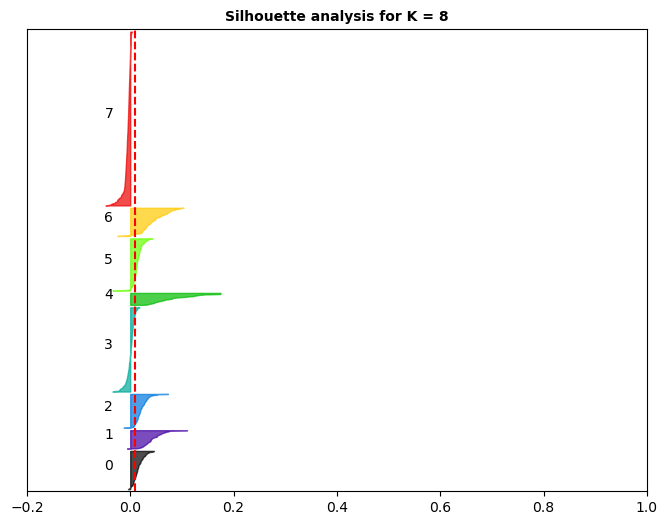

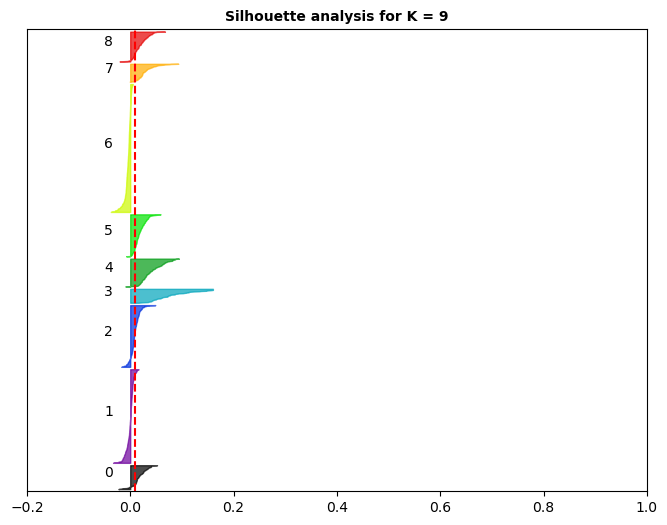

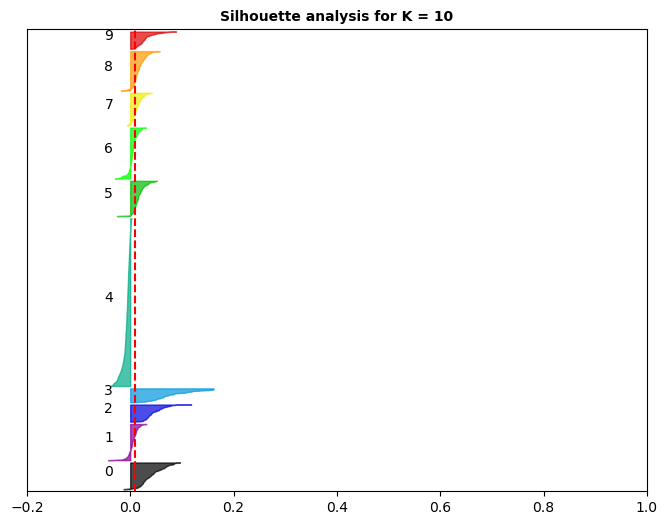

In [12]:
# Rodando Kmeans
k = 10
kmeans_results = run_KMeans(k, final_df)

# Plotando Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)



In [13]:
# Checando a média por cluster
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(final_df)
    silhouette_avg = silhouette_score(final_df, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)

Para n_clusters = 2 O score_silhouette médio é : 0.0055372311533803545
Para n_clusters = 3 O score_silhouette médio é : 0.005206381828690171
Para n_clusters = 4 O score_silhouette médio é : 0.006559978702711572
Para n_clusters = 5 O score_silhouette médio é : 0.007044534394365342
Para n_clusters = 6 O score_silhouette médio é : 0.007148406488820345
Para n_clusters = 7 O score_silhouette médio é : 0.008623224998656469
Para n_clusters = 8 O score_silhouette médio é : 0.009542126385176597
Para n_clusters = 9 O score_silhouette médio é : 0.010310369251515107
Para n_clusters = 10 O score_silhouette médio é : 0.010483492003830043


Para a escolha do melhor número de clusters analisou-se os distintos clusters em cada agrupamento através de gráficos de palavras mais dominantes em cada grupo e também pela melhor média. Concluiu-se que os grupos que mais faziam sentido entre si foi quando eles foram separados em 9 grupos.

### Cluster Analysis
Então, usaremos um histograma para observar as palavras mais dominantes em cada cluster.

In [14]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # Índices por cada cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # Retorna a pontuação média em todo o cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # Índices com top 20 pontuação
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Palavras Mais Comuns no Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

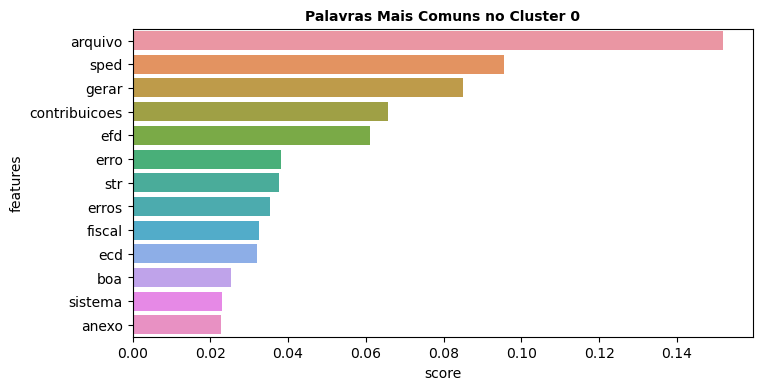

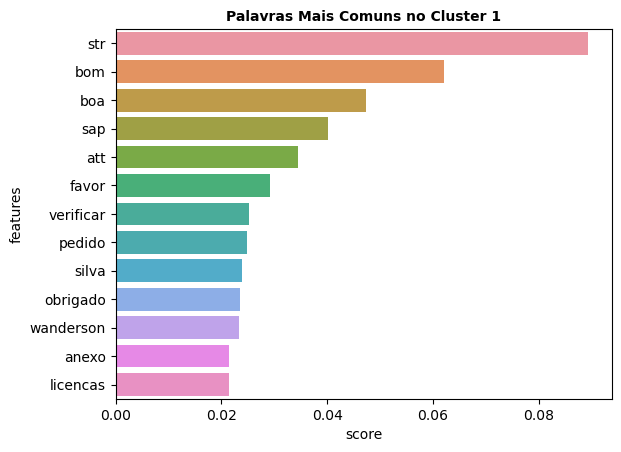

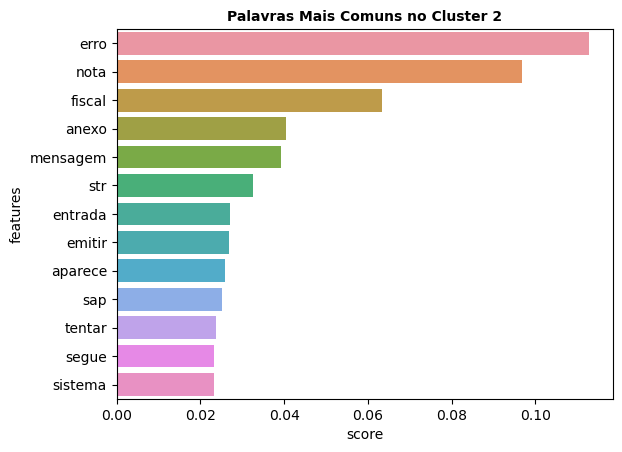

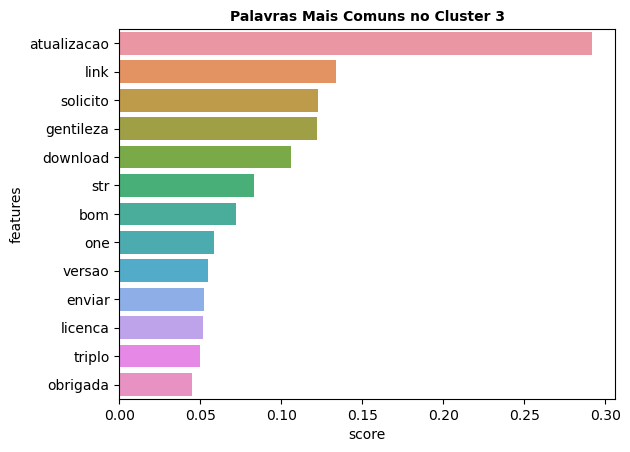

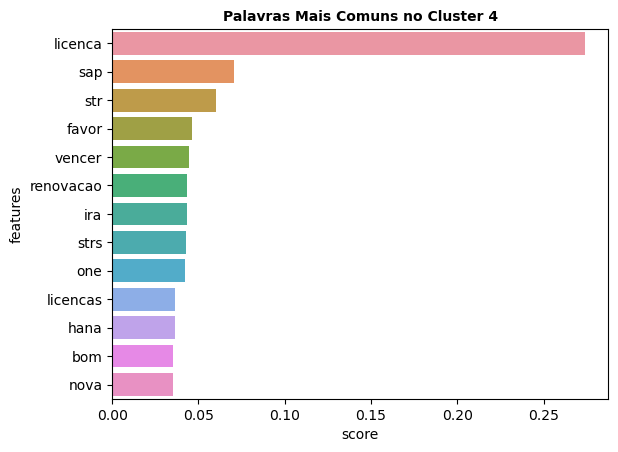

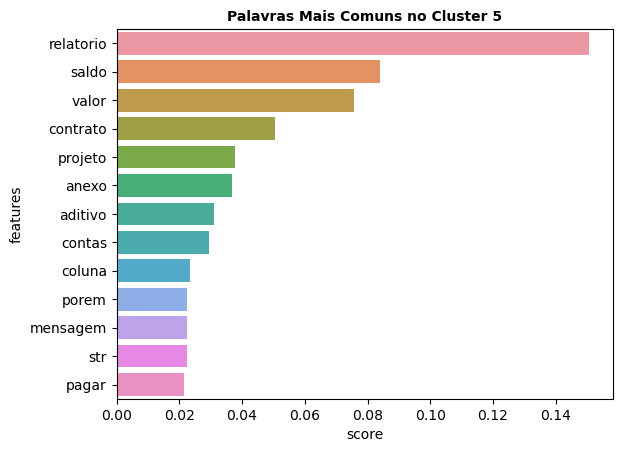

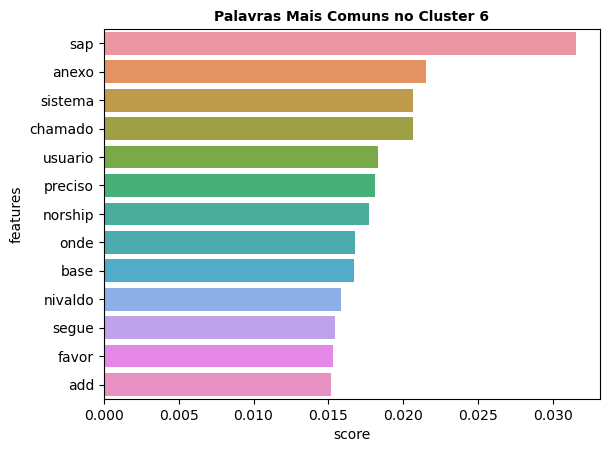

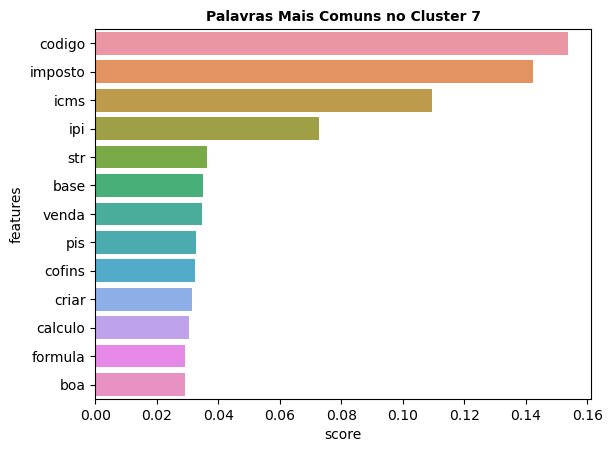

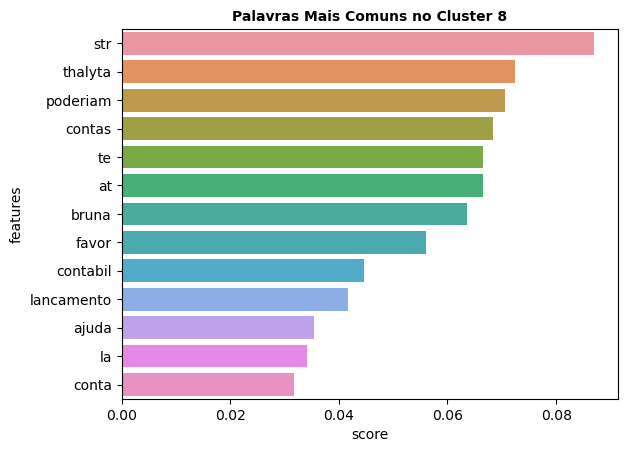

In [15]:
best_result = 9
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

### Mapa de Palavras por Cluster

In [16]:
# Transforma um dataframe de centroides em um dicionário para ser usado em  WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()


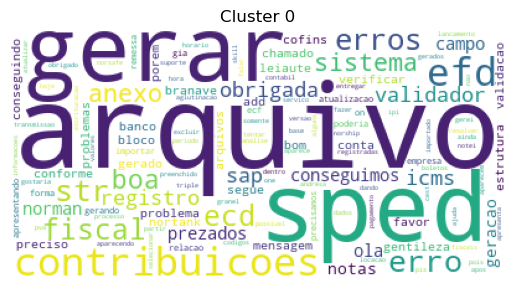

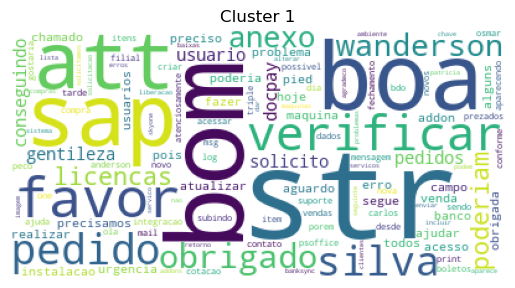

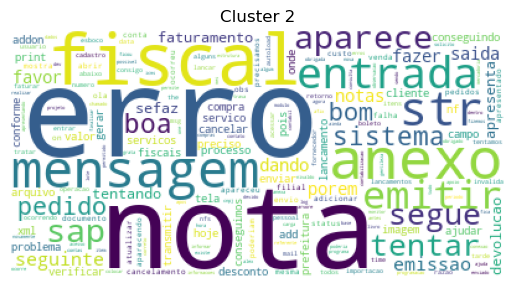

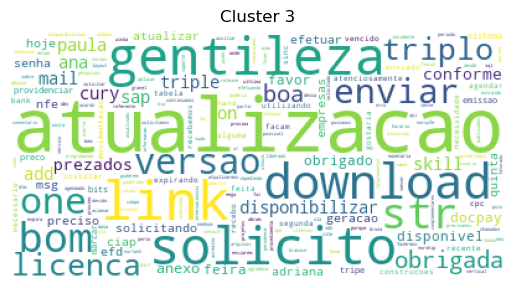

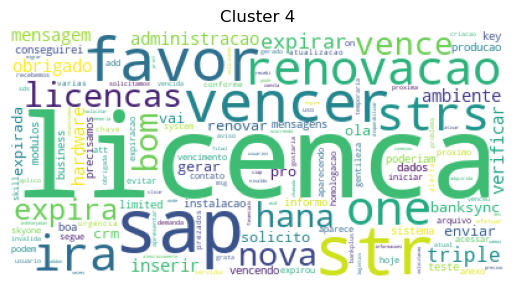

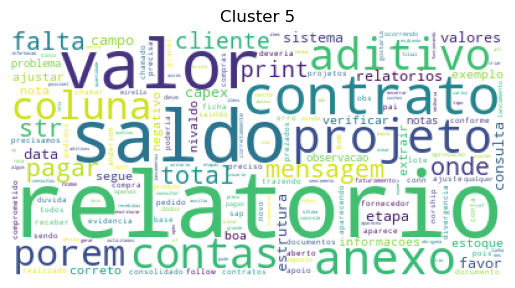

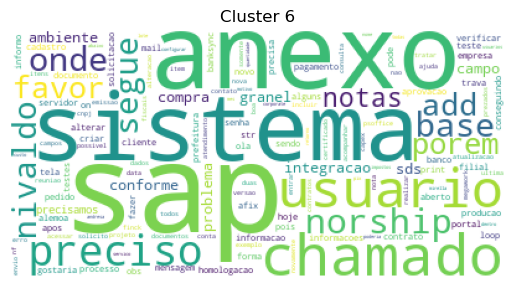

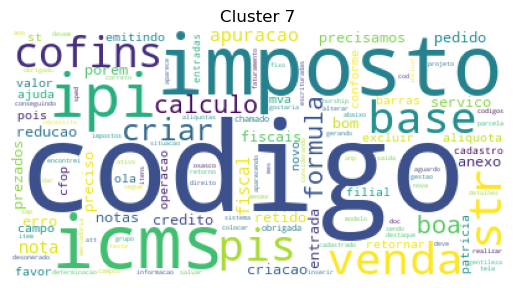

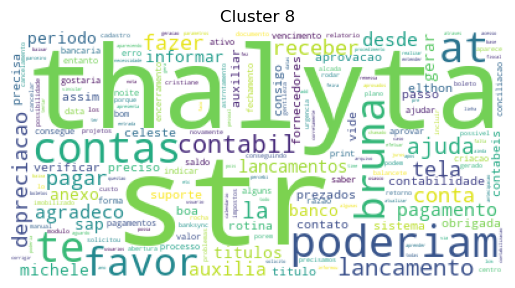

In [17]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)


Ao examinar os clusters, fica claro o tema que as palavras inferem em cada grupo. 



### Preparando o Grupo e Definindo as Categorias

In [18]:
# Criando uma coluna com os grupos
df['GRUPO'] = kmeans.labels_
df.head()

,TIPO_CHAMADO,DS_FRENTE_CHAMADO,DS_DESCRICAO_CHAMADO,LOG_INTERACAO,GRUPO
0,INCIDENTE,B1,#0121-000006,Favor incluir o código ANP nas utilizações em ...,7
1,INCIDENTE,B1,#0121-000009,Favor validar porque na carga é permitido e na...,6
2,INCIDENTE,B1,PERIODO CONTABIL,Bom dia! Ao tentar fazer os lançamentos com a...,2
3,INCIDENTE,B1,#0121-000015,"O relatório de Movimentações, em Granel Relató...",5
4,INCIDENTE,B1,#0121-000022,Ao extrair o relatório de cliente das filiais ...,5


In [19]:
# Associando os grupos (clusters) a categorias
CATEGORIA = {
    0: 'Gerar Arquivo SPED',
    1: 'Suporte SAP',
    2: 'Erros em Notas Fiscais e Pedidos no Sistema',
    3: 'Renovação Licença SAP',
    4: 'Análise de Contas, Saldo e Elaboração de Relatório de Valores a Pagar',
    5: 'Gestão de Contratos e Projetos: Aditivos, Saldo Capex e Integração com Sistema.',
    6: 'Impostos, valores e cálculos',
    7: 'Link de download da atualização da versão',
    8: 'Integração de Dados PSOffice e SAP, Campos de Registro e Logs',
}

# Crie uma coluna com os temas associados aos números
df['CATEGORIA'] = df['GRUPO'].map(CATEGORIA)

# Exiba o DataFrame resultante
df.head()

,TIPO_CHAMADO,DS_FRENTE_CHAMADO,DS_DESCRICAO_CHAMADO,LOG_INTERACAO,GRUPO,CATEGORIA
0,INCIDENTE,B1,#0121-000006,Favor incluir o código ANP nas utilizações em ...,7,Link de download da atualização da versão
1,INCIDENTE,B1,#0121-000009,Favor validar porque na carga é permitido e na...,6,"Impostos, valores e cálculos"
2,INCIDENTE,B1,PERIODO CONTABIL,Bom dia! Ao tentar fazer os lançamentos com a...,2,Erros em Notas Fiscais e Pedidos no Sistema
3,INCIDENTE,B1,#0121-000015,"O relatório de Movimentações, em Granel Relató...",5,"Gestão de Contratos e Projetos: Aditivos, Sald..."
4,INCIDENTE,B1,#0121-000022,Ao extrair o relatório de cliente das filiais ...,5,"Gestão de Contratos e Projetos: Aditivos, Sald..."


In [22]:
# Contagem dos grupos
grupo_counts = df['GRUPO'].value_counts()

# As cinco categorias mais comuns
top_3_categorias = grupo_counts.head(3)
print("As 3 categorias mais comuns:")
print(top_3_categorias)

print("\n6: 'Impostos, valores e cálculos' \n1: 'Suporte SAP' \n2: 'Erros em Notas Fiscais e Pedidos no Sistema' ")

As 3 categorias mais comuns:
6    590
1    432
2    285
Name: GRUPO, dtype: int64

6: 'Impostos, valores e cálculos' 
1: 'Suporte SAP' 
2: 'Erros em Notas Fiscais e Pedidos no Sistema' 


Observa-se que as 3 categorias que existem mais chamados são, respectivamente:

- 'Impostos, valores e cálculos' com **590 ocorrências**.
- 'Suporte SAP' com **432 ocorrências**.
- 'Erros em Notas Fiscais e Pedidos no Sistema' com **285 ocorrências**.

In [23]:
# Exportando excel com novas colunas
df.to_excel("/Users/danilo/Documents/teste_tecnico_megawork/datasets/CHAMADOS_COM_CATEGORIA.xlsx", index=False)

### Categorias Mais Comuns

As três categorias mais comuns encontradas pelo modelo, do maior para o menor em número de ocorrências, são as seguintes:

1. 'Impostos, valores e cálculos' com 590 ocorrências.
2. 'Suporte SAP' com 432 ocorrências.
3. 'Erros em Notas Fiscais e Pedidos no Sistema' com 285 ocorrências.

Esses resultados revelam as principais áreas de preocupação e assistência dentro do conjunto de chamados, proporcionando uma visão valiosa para a priorização de recursos e aprimoramento dos processos relacionados a essas categorias.

### Conclusão

Neste projeto, aplicamos com sucesso uma técnica de agrupamento de chamados para categorizar e organizar as solicitações com base em suas descrições e características. O resultado do agrupamento revelou as seguintes categorias predominantes:

- '**Categoria 0: 'Gerar Arquivo SPED''**

Esta categoria inclui chamados relacionados à geração de arquivos SPED (Sistema Público de Escrituração Digital), sugerindo que as solicitações dentro desse grupo estão relacionadas a conformidade fiscal e demais tarefas relacionadas a ela.

- **Categoria 1: 'Suporte SAP'**

Chamados agrupados nesta categoria estão associados a solicitações de suporte para o sistema SAP, assim como semelhantes a ele.

- '**Categoria 2: 'Erros em Notas Fiscais e Pedidos no Sistema''**

Esta categoria engloba chamados que abordam erros ou problemas relacionados a notas fiscais e pedidos no sistema, destacando a importância da correção desses problemas.

- '**Categoria 3: 'Renovação Licença SAP''**

Os chamados nesta categoria estão relacionados à renovação de licenças para o sistema SAP, sugerindo que o processo de manutenção de licenças é uma preocupação frequente.

- '**Categoria 4: 'Análise de Contas, Saldo e Elaboração de Relatório de Valores a Pagar''**

Chamados agrupados nesta categoria estão associados a análises financeiras, saldos e relatórios de contas a pagar, indicando um foco na gestão financeira.

- '**Categoria 5: 'Gestão de Contratos e Projetos: Aditivos, Saldo Capex e Integração com Sistema.''**

Esta categoria envolve solicitações relacionadas à gestão de contratos e projetos, incluindo aditivos, saldo de investimentos (Capex) e integração com sistemas.

- '**Categoria 6: 'Impostos, valores e cálculos''**

Os chamados nesta categoria abordam questões relacionadas a impostos, valores e cálculos, destacando a complexidade das preocupações fiscais.

- '**Categoria 7: 'Link de download da atualização da versão''**

Esta categoria inclui chamados relacionados à solicitação de links para download de atualizações de versão de software.

- '**Categoria 8: 'Integração de Dados PSOffice e SAP, Campos de Registro e Logs''**

Chamados agrupados nesta categoria estão relacionados à integração de dados entre o PSOffice e o SAP, bem como a questões de campos de registro e logs.

A categorização bem-sucedida dos chamados permite uma organização mais eficiente das solicitações, facilitando o direcionamento correto das equipes de suporte e melhorando a eficiência operacional. Este projeto demonstra o poder da Ciência de Dados na automatização e melhoria dos processos de gestão de chamados e suporte.

### Trabalhos Futuros

Certamente, aqui estão algumas sugestões de trabalhos futuros e melhorias para este projeto de agrupamento de chamados:

1. **Melhoria na Qualidade dos Dados:**
   - Investir na melhoria da qualidade dos dados, garantindo que as descrições dos chamados estejam limpas e bem formatadas. Isso pode envolver a remoção de ruídos, correção de erros de digitação e normalização do texto.

2. **Avaliação de Desempenho de Modelos Alternativos:**
   - Além do K-means, considere avaliar o desempenho de outros algoritmos de agrupamento ou técnicas de aprendizado não supervisionado baseadas em redes neurais, para determinar qual funciona melhor para o seu conjunto de dados.

3. **Uso de Embeddings de Palavras (Word Embeddings):**
   - Experimente incorporar embeddings de palavras pré-treinados, como Word2Vec ou GloVe, para melhorar a representação de texto das descrições dos chamados. Isso pode ajudar o modelo a capturar melhor o significado semântico das palavras.

4. **Exploração de Outros Recursos de Texto:**
   - Considere a extração de recursos adicionais das descrições dos chamados, como n-grams, partes do discurso, ou entidades nomeadas (NER), para capturar informações mais ricas do texto.

5. **Validação Externa:**
   - Valide os resultados do agrupamento com especialistas do domínio para garantir que as categorias atribuídas façam sentido do ponto de vista do negócio.

6. **Implementação de um Sistema em Produção:**
   - Leve o modelo de agrupamento para um ambiente de produção, onde ele possa ser usado para automatizar a categorização de novos chamados em tempo real.

7. **Integração com um Sistema de Ticketing:**
   - Integre o sistema de agrupamento com um sistema de ticketing de suporte para automatizar o encaminhamento de chamados para as equipes apropriadas com base nas categorias atribuídas.

8. **Análise de Tendências Temporais:**
   - Realize uma análise de tendências temporais para entender como as categorias de chamados evoluem ao longo do tempo. Isso pode ajudar a prever problemas futuros.

9. **Feedback Contínuo do Usuário:**
   - Implemente um sistema de feedback contínuo dos usuários para ajustar e melhorar as categorias à medida que as necessidades do negócio evoluem.

10. **Aprimoramento da Apresentação de Resultados:**
    - Melhore a apresentação dos resultados, incluindo visualizações interativas e relatórios automatizados para as equipes de suporte e gerenciamento.

Lembrando que a escolha das melhorias futuras deve depender das necessidades específicas da Megawork e dos recursos disponíveis. Cada uma dessas sugestões pode levar a aprimoramentos significativos no projeto, proporcionando maior eficiência.